In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from my_mnist import load_mnist
train, validation, test = load_mnist()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


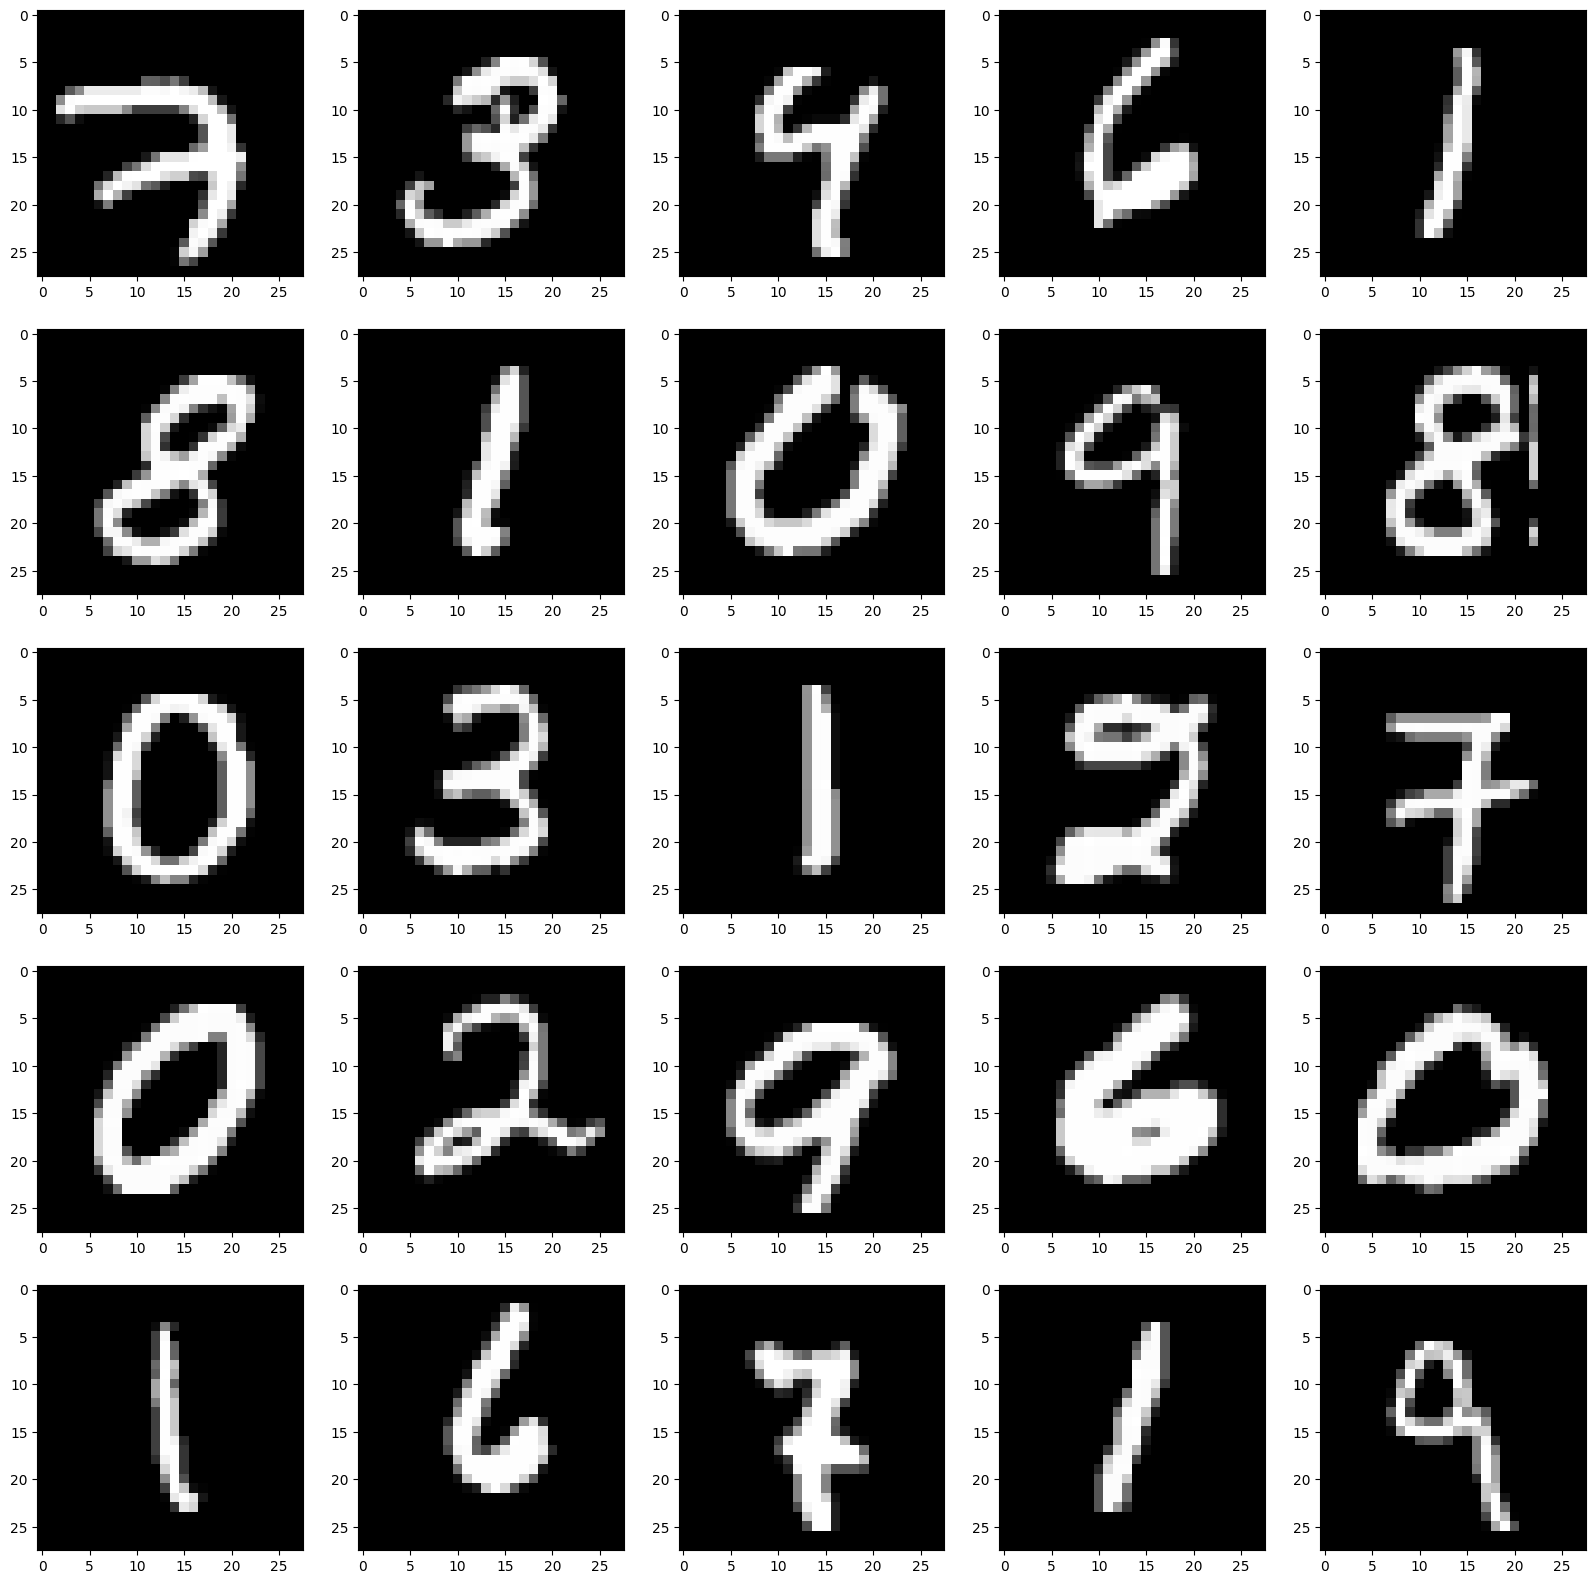

In [4]:
x, y = train[0].reshape(-1, 28, 28), train[1]
x_validation, y_validation = validation[0].reshape(-1, 28, 28), validation[1]
x_test, y_test = test

fig, axs = plt.subplots(5,5, figsize=(20,20))
x_subset = x[y]
for i in range(5):
    for j in range(5):
        idx = 5*i + j
        axs[i,j].imshow(x[idx], cmap="gray")

In [5]:
# Реализация класса my_PCA
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        # Центрирование данных
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # SVD
        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # Собственные векторы
        self.components = Vt

        # Собственные значения = s^2 / (n-1)
        self.explained_variance = (s ** 2) / (X.shape[0] - 1)

        # Важно: если запросили больше компонент, чем доступно
        max_components = min(X.shape[0], X.shape[1])
        if self.n_components is not None:
            if self.n_components > max_components:
                print(f"Внимание: запрошено {self.n_components} компонент, "
                      f"но доступно только {max_components}")
                self.n_components = max_components

            self.components = self.components[:self.n_components]
            self.explained_variance = self.explained_variance[:self.n_components]

        return self

    def transform(self, x):
        if self.mean is None or self.components is None:
            raise ValueError("Сначала нужно вызвать метод fit()")

        x_centered = x - self.mean
        x_transformed = np.dot(x_centered, self.components.T)
        return x_transformed

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

In [6]:
# Реализация класса my_kNN
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.x_train = None
        self.y_train = None

    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        return self

    def predict(self, X):
        # Вычисляем все расстояния сразу (матрица размерности [n_test, n_train])
        distances = np.sqrt(((X[:, np.newaxis] - self.x_train) ** 2).sum(axis=2))

        # Находим индексы k ближайших соседей для каждого тестового примера
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Получаем метки соседей
        nearest_labels = self.y_train[nearest_indices]

        # Находим наиболее частую метку для каждого тестового примера
        predictions = []
        for labels in nearest_labels:
            unique, counts = np.unique(labels, return_counts=True)
            predictions.append(unique[np.argmax(counts)])

        return np.array(predictions)

Анализ собственных значений PCA...


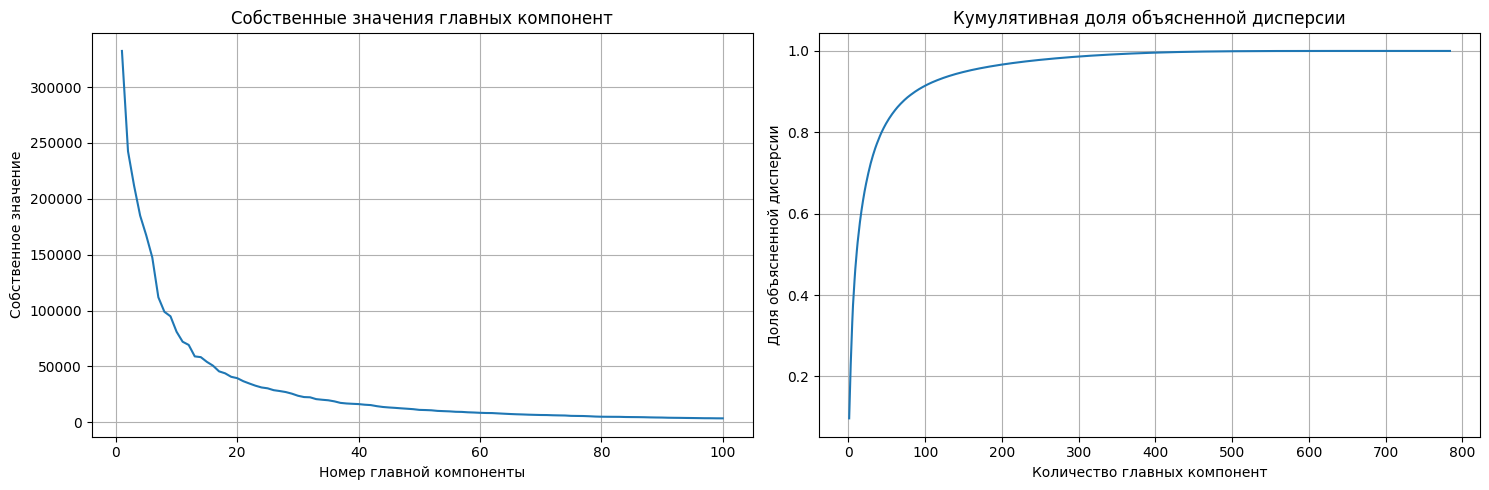

Доля дисперсии, покрываемая первыми 15 главными компонентами: 0.5791 (57.91%)


In [7]:
# Анализ собственных значений PCA
print("Анализ собственных значений PCA...")
x_2d = x.reshape(-1, 28*28)
pca_full = my_PCA()
pca_full.fit(x_2d)

# График собственных значений
components_to_plot = min(100, len(pca_full.explained_variance))  # Берем минимум из 100 и доступных компонент

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, components_to_plot + 1), pca_full.explained_variance[:components_to_plot])
plt.xlabel('Номер главной компоненты')
plt.ylabel('Собственное значение')
plt.title('Собственные значения главных компонент')
plt.grid(True)

# График кумулятивной дисперсии
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca_full.explained_variance) / np.sum(pca_full.explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Количество главных компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Кумулятивная доля объясненной дисперсии')
plt.grid(True)

plt.tight_layout()
plt.show()

# Анализ первых 15 компонент
first_15_variance = cumulative_variance[14]
print(f"Доля дисперсии, покрываемая первыми 15 главными компонентами: {first_15_variance:.4f} ({first_15_variance*100:.2f}%)")

Визуализация данных в пространстве первых двух главных компонент...


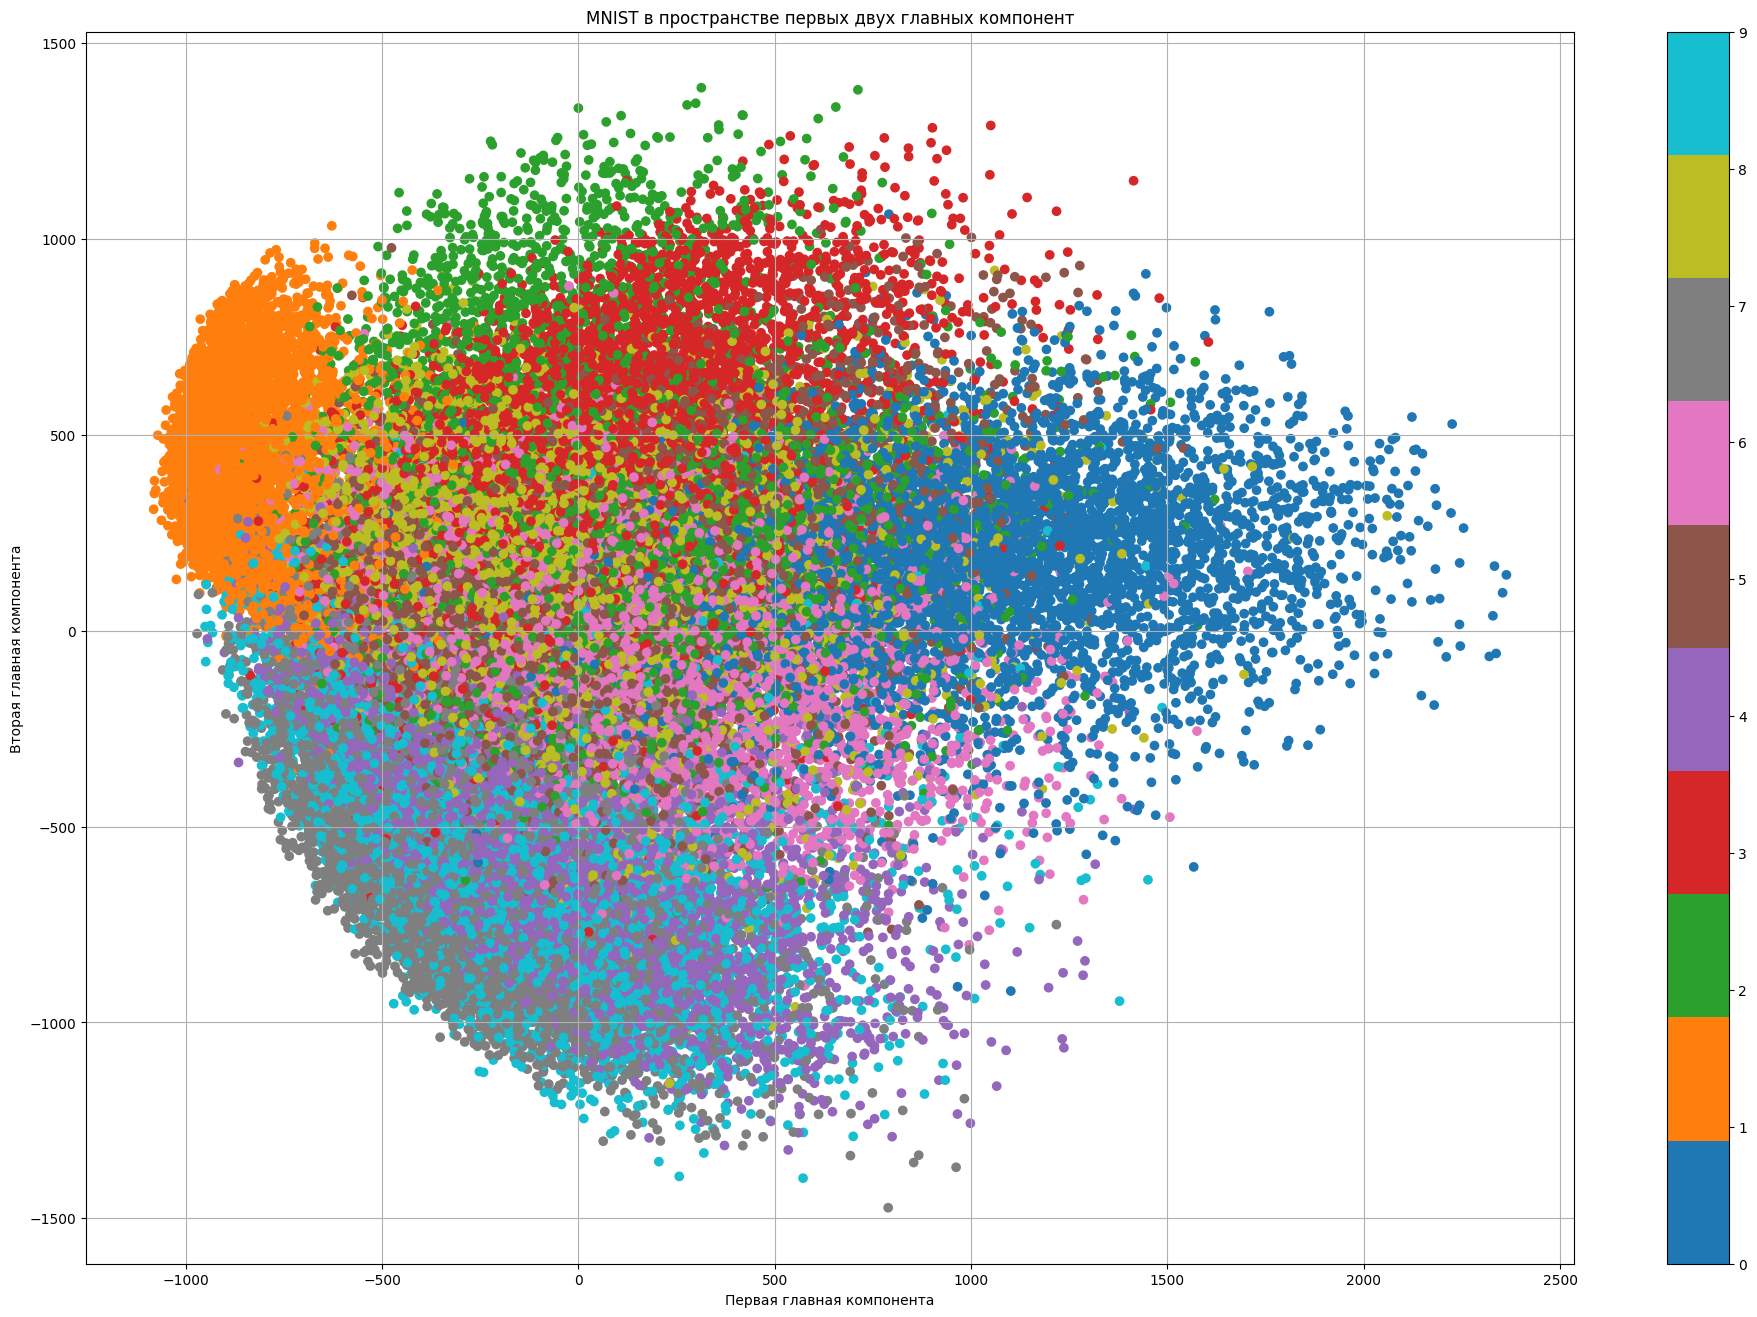

In [9]:
# Визуализация данных в пространстве первых двух главных компонент
print("Визуализация данных в пространстве первых двух главных компонент...")
pca_2d = my_PCA(n_components=2)
x_pca_2d = pca_2d.fit_transform(x_2d)

plt.figure(figsize=(24, 16))
scatter = plt.scatter(x_pca_2d[:, 0], x_pca_2d[:, 1], c=y, cmap='tab10')
plt.colorbar(scatter)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('MNIST в пространстве первых двух главных компонент')
plt.grid()
plt.show()

In [10]:
# Тестирование kNN на исходных данных
print("Тестирование kNN на исходных данных...")

# Для ускорения вычислений возьмем подвыборку
sample_size = 1000
indices = np.random.choice(len(x_2d), sample_size, replace=False)
X_sample = x_2d[indices]
y_sample = y[indices]

# Нормализация данных
X_sample_norm = (X_sample - np.mean(X_sample, axis=0)) / (np.std(X_sample, axis=0) + 1e-8)

# Разбиваем на обучающую и тестовую выборки
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_sample_norm, y_sample, test_size=0.2, random_state=42)

# Создаем и обучаем классификатор kNN
knn = my_kNN(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

# Предсказания и оценка точности
y_pred = knn.predict(X_test_knn)
accuracy = accuracy_score(y_test_knn, y_pred)
accuracy_orig = accuracy

print(f"Точность kNN на исходных данных: {accuracy:.4f} ({accuracy*100:.2f}%)")

Тестирование kNN на исходных данных...
Точность kNN на исходных данных: 0.8100 (81.00%)


In [11]:
# Оптимизация параметров kNN с PCA
print("Оптимизация параметров kNN с PCA...")

# Выборка
sample_size = 10000
indices = np.random.choice(len(x), sample_size, replace=False)
x_opt = x_2d[indices]
y_opt = y[indices]

X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    x_opt, y_opt, test_size=0.2, random_state=42
)

# Параметры для поиска
n_components_list = [1, 2, 5, 10, 15, 20, 30, 50, 64]
n_neighbors_list = [1, 3, 5, 7, 10, 15, 30]

results = []
best_accuracy = 0
best_params = (0, 0)

# Матрица для быстрого доступа к результатам
accuracy_matrix = np.zeros((len(n_components_list), len(n_neighbors_list)))

# Вычисляем PCA для всех компонент
print("\nВычисление PCA...")
pca_models = {}
X_train_pca_dict = {}
X_test_pca_dict = {}

for i, n_components in enumerate(n_components_list):
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_opt)
    X_test_pca = pca.transform(X_test_opt)

    pca_models[n_components] = pca
    X_train_pca_dict[n_components] = X_train_pca
    X_test_pca_dict[n_components] = X_test_pca
    print(f"  PCA для {n_components} компонент")

# Основной цикл оптимизации
print("\nОценка комбинаций параметров kNN...")

for i, n_components in enumerate(n_components_list):
    X_train_pca = X_train_pca_dict[n_components]
    X_test_pca = X_test_pca_dict[n_components]

    for j, n_neighbors in enumerate(n_neighbors_list):
        # Обучаем kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_opt)
        y_pred = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test_opt, y_pred)

        # Сохраняем результаты
        results.append((n_components, n_neighbors, accuracy))
        accuracy_matrix[i, j] = accuracy

        # Обновляем лучший результат
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (n_components, n_neighbors)

        # Быстрый вывод прогресса
        if len(results) % 5 == 0:
            print(f"  {len(results)}/{len(n_components_list)*len(n_neighbors_list)} "
                  f"({len(results)/(len(n_components_list)*len(n_neighbors_list))*100:.1f}%)")


# Результаты
print("\n" + "="*60)
print("Результаты:")

# Быстрый вывод топ-10 результатов
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

print("\nТоп-10 комбинаций параметров:")
for rank, (comp, neigh, acc) in enumerate(sorted_results[:10], 1):
    star = " +" if (comp, neigh) == best_params else ""
    print(f"{rank:2d}. Компоненты: {comp:2d}, Соседи: {neigh:2d}, "
          f"Точность: {acc:.4f}{star}")

print(f"\n{'='*60}")
print(f"Лучшие параметры:")
print(f"  Компоненты: {best_params[0]}")
print(f"  Соседи: {best_params[1]}")
print(f"  Точность: {best_accuracy:.4f}")



Оптимизация параметров kNN с PCA...

Вычисление PCA...
  PCA для 1 компонент
  PCA для 2 компонент
  PCA для 5 компонент
  PCA для 10 компонент
  PCA для 15 компонент
  PCA для 20 компонент
  PCA для 30 компонент
  PCA для 50 компонент
  PCA для 64 компонент

Оценка комбинаций параметров kNN...
  5/63 (7.9%)
  10/63 (15.9%)
  15/63 (23.8%)
  20/63 (31.7%)
  25/63 (39.7%)
  30/63 (47.6%)
  35/63 (55.6%)
  40/63 (63.5%)
  45/63 (71.4%)
  50/63 (79.4%)
  55/63 (87.3%)
  60/63 (95.2%)

Результаты:

Топ-10 комбинаций параметров:
 1. Компоненты: 50, Соседи:  3, Точность: 0.9565 +
 2. Компоненты: 64, Соседи:  1, Точность: 0.9565
 3. Компоненты: 30, Соседи:  5, Точность: 0.9560
 4. Компоненты: 50, Соседи:  1, Точность: 0.9560
 5. Компоненты: 30, Соседи:  3, Точность: 0.9555
 6. Компоненты: 30, Соседи:  1, Точность: 0.9550
 7. Компоненты: 64, Соседи:  3, Точность: 0.9550
 8. Компоненты: 30, Соседи:  7, Точность: 0.9520
 9. Компоненты: 50, Соседи:  5, Точность: 0.9520
10. Компоненты: 50, Соседи:

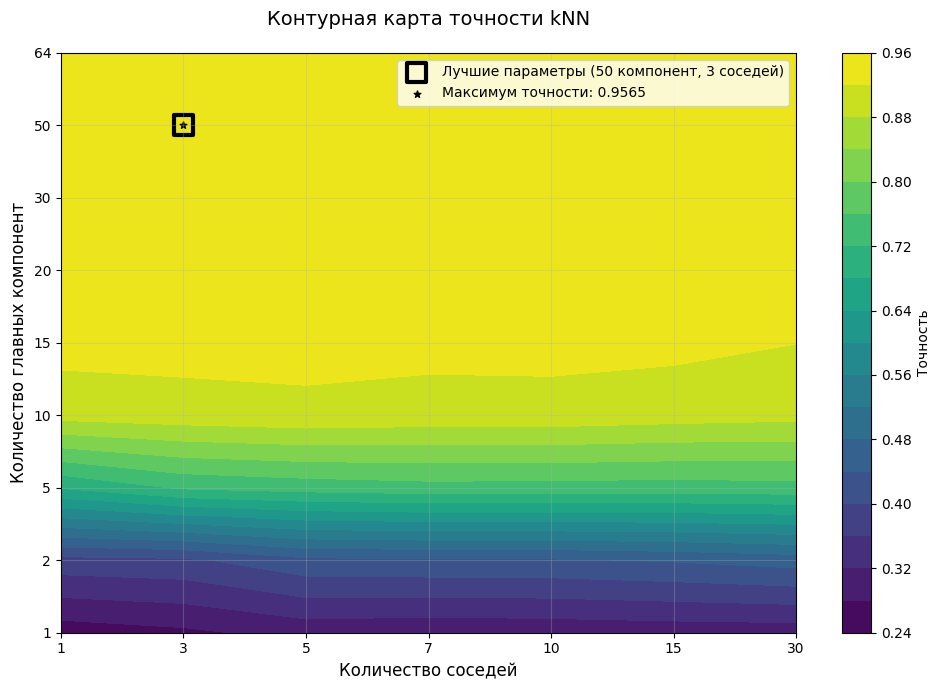

In [13]:
# Визуализация результатов

# Координаты лучших параметров
best_comp_idx = n_components_list.index(best_params[0])
best_neigh_idx = n_neighbors_list.index(best_params[1])

# Линии уровня для параметров kNN с PCA
plt.figure(figsize=(10, 7))
contour = plt.contourf(range(len(n_neighbors_list)),
                       range(len(n_components_list)),
                       accuracy_matrix,
                       levels=20,
                       cmap='viridis')

plt.colorbar(contour, label='Точность')
plt.xticks(range(len(n_neighbors_list)), n_neighbors_list)
plt.yticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Количество соседей', fontsize=12)
plt.ylabel('Количество главных компонент', fontsize=12)
plt.title('Контурная карта точности kNN', fontsize=14, pad=20)

# Выделяем лучшие параметры на контурной карте
plt.scatter(best_neigh_idx, best_comp_idx,
            s=200, marker='s',
            facecolor='none', edgecolor='black',
            linewidth=3, label=f'Лучшие параметры ({best_params[0]} компонент, {best_params[1]} соседей)')

# Добавляем маркер максимума
max_indices = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)
plt.scatter(max_indices[1], max_indices[0],
            s=25, marker='*',
            color='black', linewidth=1,
            label=f'Максимум точности: {best_accuracy:.4f}')

plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Выводы
print("Результаты:")
print("="*60)

print(f"\nПервые 15 главных компонент покрывают {first_15_variance:.4f} ({first_15_variance*100:.2f}%) доли дисперсии")
print("В первых двух компонентах классы линейно слабо (не)разделимы")
print(f"\nТочность kNN на исходных данных: {accuracy_orig:.4f} ({accuracy_orig*100:.2f}%)")

print(f"\nЛучшие параметры (kNN с использованием PCA):")
print(f"  Компоненты: {best_params[0]}")
print(f"  Соседи: {best_params[1]}")
print(f"  Точность: {best_accuracy:.4f}")

print("\nТочность kNN на исходных данных по сравнению с использованием PCA с учшими параметрами: ")
print(f"  {accuracy_orig:.4f} {'<' if accuracy_orig < best_accuracy else '>='} {best_accuracy:.4f}")

Результаты:

Первые 15 главных компонент покрывают 0.5791 (57.91%) доли дисперсии
В первых двух компонентах классы линейно слабо (не)разделимы

Точность kNN на исходных данных: 0.8100 (81.00%)

Лучшие параметры (kNN с использованием PCA):
  Компоненты: 50
  Соседи: 3
  Точность: 0.9565

Точность kNN на исходных данных по сравнению с использованием PCA с учшими параметрами: 
  0.8100 < 0.9565
